<a href="https://colab.research.google.com/github/the7thanony/Alzheimer-s-Detection-using-CNN/blob/main/Alzheimer's_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os

import pickle

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# deep learning
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, Input

from tensorflow.keras.layers import RandomRotation, RandomContrast, RandomZoom, RandomFlip, RandomTranslation

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Training Model callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# general parameters

plt.rcParams["figure.figsize"] = (18, 9)
plt.rcParams.update({'font.size': 15})

In [ ]:
# Check if GPU is available
print(f'Tensorflow Version: {tf.__version__}')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  print("GPU Available:", gpus[0])
else:
  print("No GPU available")

Tensorflow Version: 2.17.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]

In [ ]:
path_train = "/content/drive/MyDrive/Alzheimer_s Dataset/train"
path_test = "/content/drive/MyDrive/Alzheimer_s Dataset/test"

train_ds = image_dataset_from_directory(
    path_train,
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

val_ds = image_dataset_from_directory(
    path_test,
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 1279 files belonging to 4 classes.
Using 255 files for validation.


In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)
print(NUM_CLASSES)

4


In [ ]:
# Extract labels from datasets
def extract_labels(dataset):
    labels = []
    for _, label_batch in dataset:
        labels.extend(label_batch.numpy())
    return labels

train_labels = extract_labels(train_ds)
val_labels = extract_labels(val_ds)

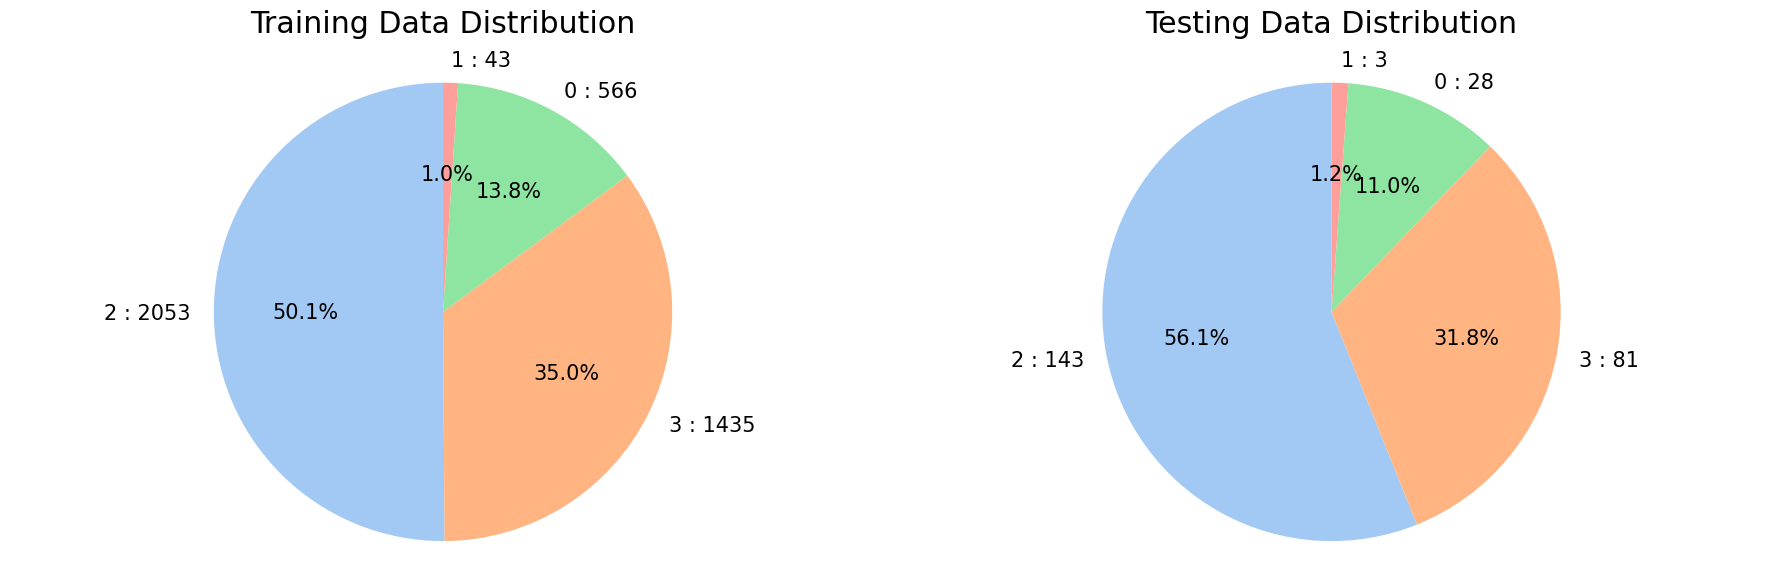

In [ ]:
def plot_pie_chart(distribution, title, ax):
    distribution_series = pd.Series(distribution)
    counts = distribution_series.value_counts()
    ax.pie(counts, labels=[f'{label} : {count}' for label, count in zip(counts.index, counts)],
           autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
    ax.axis('equal')
    ax.set_title(title,pad=20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_pie_chart(train_labels, "Training Data Distribution", axes[0])
plot_pie_chart(val_labels, "Testing Data Distribution", axes[1])

plt.tight_layout()
plt.show()


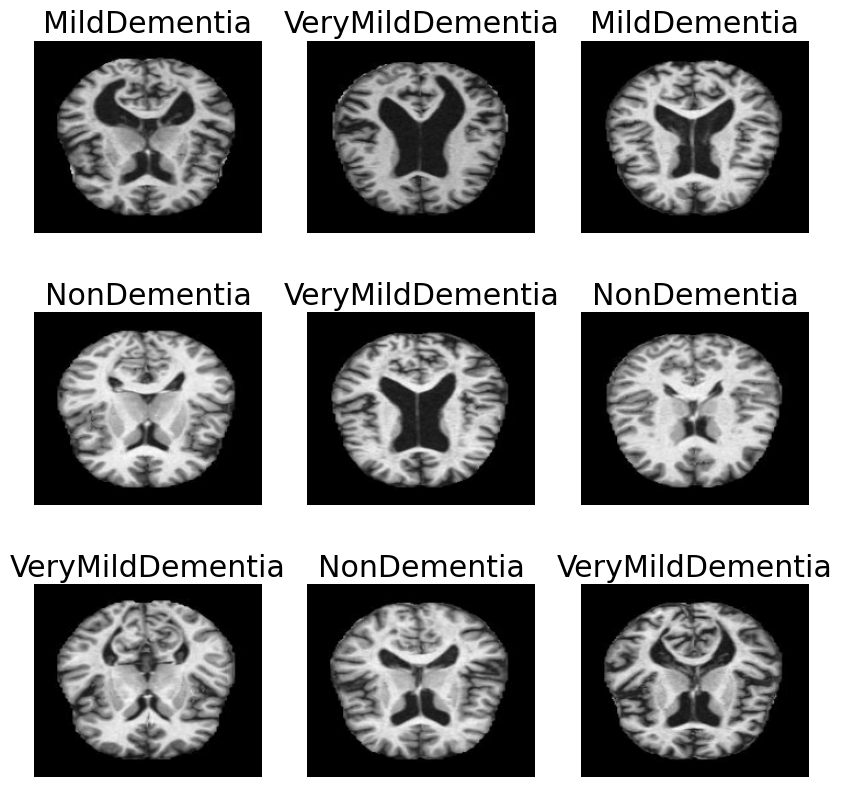

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch from the dataset
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [ ]:
# data_augmentation = Sequential([
#     RandomFlip("horizontal"),
#     RandomRotation(0.02, fill_mode='constant'),
#     RandomContrast(0.1),
#     RandomZoom(height_factor=0.01, width_factor=0.05),
#     RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
# ])

# # Training augmentation and normalization
# def preprocess_train(image, label):
#     # Apply data augmentation and Normalize
#     image = data_augmentation(image) / 255.0
#     return image, label

# # For test dataset only applying normalization
# def preprocess_test(image, label):
#     return image / 255.0, label

# # Apply transformation to training and testing datasets
# train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
# test_ds = val_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block



def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model


with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )


In [ ]:
# Callbacks

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.keras",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=100
)

Epoch 1/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - auc: 0.7231 - loss: 1.3450 - val_auc: 0.7072 - val_loss: 20.8692 - learning_rate: 0.0100
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - auc: 0.8143 - loss: 0.9826 - val_auc: 0.7272 - val_loss: 4.6781 - learning_rate: 0.0089
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - auc: 0.8171 - loss: 0.9695 - val_auc: 0.7072 - val_loss: 8.1142 - learning_rate: 0.0079
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - auc: 0.8206 - loss: 0.9539 - val_auc: 0.5451 - val_loss: 1.4880 - learning_rate: 0.0071
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - auc: 0.8292 - loss: 0.9276 - val_auc: 0.7020 - val_loss: 1.1279 - learning_rate: 0.0063
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - auc: 0.8327 - loss: 0.9269 - val_auc: 0.5710 - val_loss: 1.4544 - learning_rate: 0.0056
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - auc: 0.8345 - loss: 0.9149 - val_auc: 0.6000 - val_loss: 1.4333 - learn

In [ ]:
# Loading saved model
model = load_model('alzheimer_model.keras')

# Convert dataset to numpy arrays for evaluation
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.extend(image_batch.numpy())
        labels.extend(label_batch.numpy())
    return np.array(images), np.array(labels)

val_images, val_labels = dataset_to_numpy(val_ds)
val_images = val_images / 255.0

train_images, train_labels = dataset_to_numpy(train_ds)
train_images = train_images / 255.0


loss, accuracy = model.evaluate(val_images, val_labels)
print("Loss of the model is - ", loss)
print("Accuracy of the model is - ", accuracy * 100, "%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - auc: 0.4142 - loss: 1262.0248
Loss of the model is -  1278.267333984375
Accuracy of the model is -  40.653592348098755 %


In [ ]:
# Save the history
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


# Load the training history
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

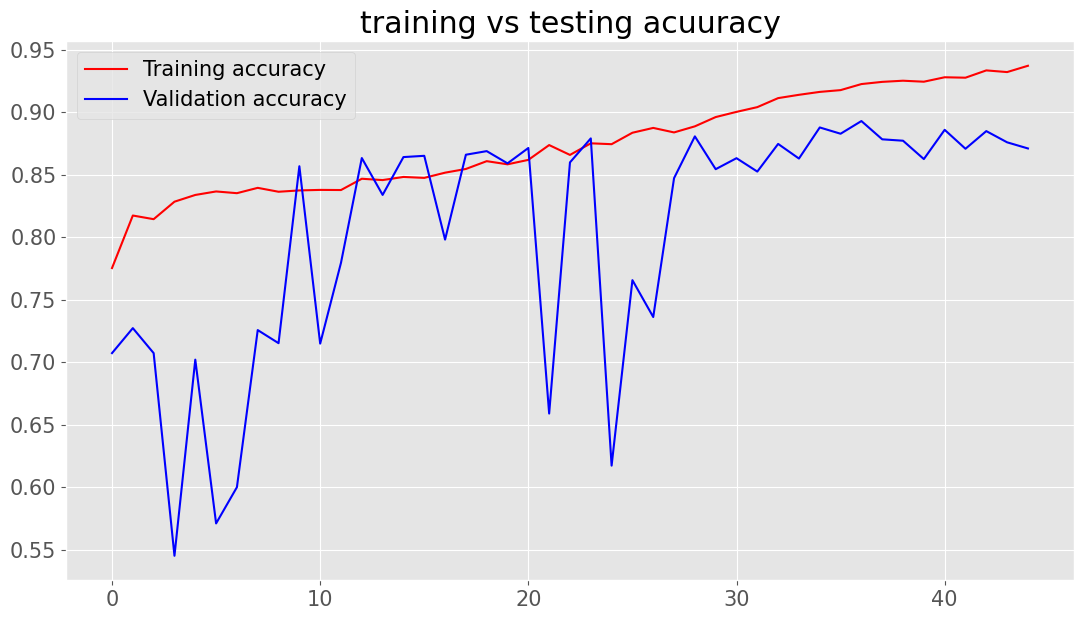

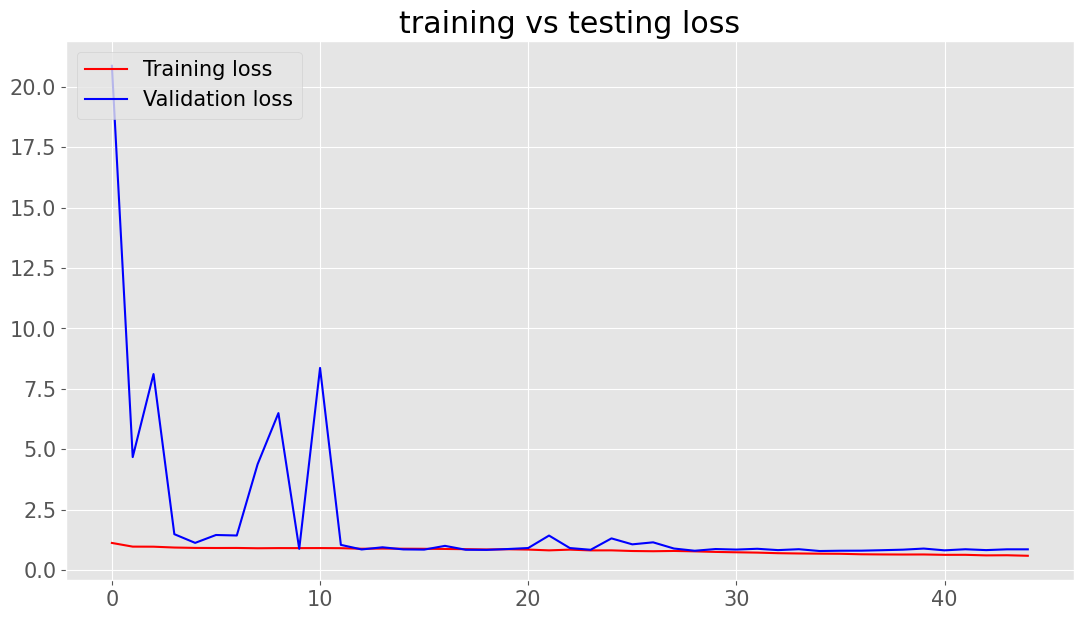

In [ ]:
# Extract the data
acc = history['auc']
val_acc = history['val_auc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

# Plot accuracy
fig = plt.figure(figsize=(13,7))
plt.title("training vs testing acuuracy")
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot loss
fig = plt.figure(figsize=(13,7))
plt.title("training vs testing loss")
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# predict the test images
predictions_prob = model.predict(val_images)
predictions = (predictions_prob > 0.5).astype(int)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
print(classification_report(val_labels, predictions, target_names = ['MildDemented (Class 0)','ModerateDemented (Class 1)','NonDemented (Class 3)','VeryMildDemented (Class 4)']))

                            precision    recall  f1-score   support

    MildDemented (Class 0)       0.11      1.00      0.20        28
ModerateDemented (Class 1)       0.00      0.00      0.00         3
     NonDemented (Class 3)       0.00      0.00      0.00       143
VeryMildDemented (Class 4)       0.00      0.00      0.00        81

                 micro avg       0.11      0.11      0.11       255
                 macro avg       0.03      0.25      0.05       255
              weighted avg       0.01      0.11      0.02       255
               samples avg       0.11      0.11      0.11       255



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


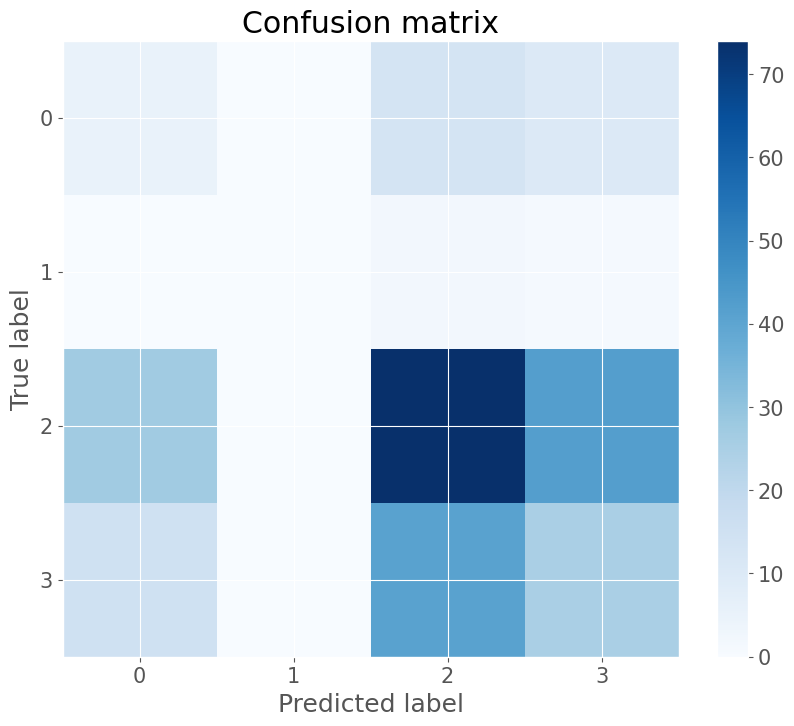

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
y_pred = model.predict(val_ds)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert validation observations to one hot vectors
y_true = np.concatenate([y for x, y in val_ds], axis=0)
# Convert validation observations to classes
y_true_classes = np.argmax(y_true, axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()